In [9]:
## python通过ssh通道连接PostgreSQL

from sshtunnel import SSHTunnelForwarder
import psycopg2
import pandas as pd
 
server = SSHTunnelForwarder(
    # 指定ssh登录的跳转机的address
    ssh_address_or_host=('gateway-bastion-azr-cne2.dktapp.cloud',22),# 分别对应填写上图中的 1 ， 2 位置的参数
    ssh_username='wallixusr@local@INFFN1IFG01:SSH:llou19', # 对应上图的 3 位置的参数，即ssh用户名
    #设置密钥
    ssh_password = 'Lz3080546!', # 对应上图的 4 位置的参数，即ssh用户密码
 
    # 设置数据库服务地址及端口
    remote_bind_address=('dmt-pgs-prd.pg.rds.aliyuncs.com' , 1921)) # 要连接的数据库地址、端口号，分别对应下图中的 1,2 位置的参数
server.start()
conn = psycopg2.connect(database = 'dw', # 要连接的数据库名，对应下图的 3 位置的参数
                            user = 'llou19',     # 要连接的数据库的用户名，对应下图的 4 位置的参数
                            password = 'hVNGMRZuNwJ0iOQ6', #要连接的数据库的用户密码，对应下图的 5 位置的参数
                            host = '127.0.0.1',    # 此处必须是是127.0.0.1
                            port = server.local_bind_port)

In [6]:
month = 10
transfer_split_query = ("""select ship.platform_name,total_order,transfer_order,split_order
from 
(select platform_name,COUNT(distinct order_bn) as total_order
from 
(select  order_bn,logi_no,platform_name,case when adj_warehouse ='燕郊' then 'YJ'
				when adj_warehouse ='东莞' then 'DG'
				when adj_warehouse ='花桥' then 'HQ' 
				when adj_warehouse ='武汉' then 'WH'  end as actual_warehouse
from bi.f_transport_omni fto  
where ship_time between '2022-{a}-01 00:00:00' and '2022-{b}-01 00:00:00'   and adj_warehouse   in ('燕郊','东莞','花桥','武汉'))f
group by platform_name) ship
left join 
(select platform_name,COUNT(distinct order_bn) as transfer_order
from 
(select  *,case when adj_warehouse ='燕郊' then 'YJ'
				when adj_warehouse ='东莞' then 'DG'
				when adj_warehouse ='花桥' then 'HQ' 
				when adj_warehouse ='武汉' then 'WH'  end as actual_warehouse
from bi.f_transport_omni fto  where ship_time between '2022-{a}-01 00:00:00' and '2022-{b}-01 00:00:00'   and adj_warehouse   in ('燕郊','东莞','花桥'))f
where actual_warehouse != "Default_warehouse"     and order_bn  in
(select order_bn  from bi.f_transport_omni fto  
where ship_time between '2022-{a}-01 00:00:00' and '2022-{b}-01 00:00:00'
group by order_bn
having count(distinct logi_no)= 1)
group by platform_name) transfer
on ship.platform_name = transfer.platform_name
left join 
(select platform_name,COUNT(distinct order_bn) as split_order
from 
(select  *
from bi.f_transport_omni fto  where ship_time between '2022-{a}-01 00:00:00' and '2022-{b}-01 00:00:00'   and adj_warehouse   in ('燕郊','东莞','花桥','武汉'))f
where     order_bn  in
(select order_bn  from bi.f_transport_omni fto  
where ship_time between '2022-{a}-01 00:00:00' and '2022-{b}-01 00:00:00'
group by order_bn
having count(distinct logi_no)>1)
group by platform_name) split 
on ship.platform_name = split.platform_name """).format(a = month, b = month+1)

In [7]:
cur = conn.cursor()
cur.execute(transfer_split_query)
rows = cur.fetchall()
pre_sale_order = pd.DataFrame(rows,columns = ['platform_name','total_order','transfer_order','split_order'])

In [19]:
pre_sale_order = pre_sale_order.fillna(0)

In [177]:
month_list =['01','02','03','04','05','06','07','08','09','10','11','12']
year = 2022
year_month = str(year)+'/'+month_list[0]
pre_sale_order['month'] =year_month

In [178]:
pre_sale_order

,platform_name,total_order,transfer_order,split_order,month
0,Decathlon天猫旗舰店,590427,66180,2062.0,2022/01
1,mini program,92137,21254,1460.0,2022/01
2,PINGAN,3034,1349,0.0,2022/01
3,迪卡侬CUBE,7654,1929,347.0,2022/01
4,迪卡侬京东旗舰店,64708,10287,904.0,2022/01
5,迪卡侬儿童天猫旗舰店,53717,5779,252.0,2022/01
6,迪卡侬抖音旗舰店,26729,4338,25.0,2022/01
7,锦江之星JINJIANG,123,14,0.0,2022/01


#### 1.1分月份拆转单情况

In [2]:
##  拆转单
import datetime
transfer_split_order_total = pd.DataFrame(columns = ['platform_name','total_order','transfer_order','split_order','month'])
month_list =['01','02','03','04','05','06','07','08','09','10','11','12']
year = 2022
for i in range(0,len(month_list)):
    start_time = datetime.datetime.now()  
    transfer_split_query = ("""select ship.platform_name,total_order,transfer_order,split_order
from 
(select platform_name,COUNT(distinct order_bn) as total_order
from 
(select  order_bn,logi_no,platform_name,case when adj_warehouse ='燕郊' then 'YJ'
				when adj_warehouse ='东莞' then 'DG'
				when adj_warehouse ='花桥' then 'HQ' 
				when adj_warehouse ='武汉' then 'WH'  end as actual_warehouse
from bi.f_transport_omni fto  
where ship_time between '{c}-{a}-01 00:00:00' and '{c}-{b}-01 00:00:00'   and adj_warehouse   in ('燕郊','东莞','花桥','武汉'))f
group by platform_name) ship
left join 
(select platform_name,COUNT(distinct order_bn) as transfer_order
from 
(select  *,case when adj_warehouse ='燕郊' then 'YJ'
				when adj_warehouse ='东莞' then 'DG'
				when adj_warehouse ='花桥' then 'HQ' 
				when adj_warehouse ='武汉' then 'WH'  end as actual_warehouse
from bi.f_transport_omni fto  where ship_time between '{c}-{a}-01 00:00:00' and '{c}-{b}-01 00:00:00'   and adj_warehouse   in ('燕郊','东莞','花桥'))f
where actual_warehouse != "Default_warehouse"     and order_bn  in
(select order_bn  from bi.f_transport_omni fto  
where ship_time between '{c}-{a}-01 00:00:00' and '{c}-{b}-01 00:00:00'
group by order_bn
having count(distinct logi_no)= 1)
group by platform_name) transfer
on ship.platform_name = transfer.platform_name
left join 
(select platform_name,COUNT(distinct order_bn) as split_order
from 
(select  *
from bi.f_transport_omni fto  where ship_time between '{c}-{a}-01 00:00:00' and '{c}-{b}-01 00:00:00'   and adj_warehouse   in ('燕郊','东莞','花桥','武汉'))f
where     order_bn  in
(select order_bn  from bi.f_transport_omni fto  
where ship_time between '{c}-{a}-01 00:00:00' and '{c}-{b}-01 00:00:00'
group by order_bn
having count(distinct logi_no)>1)
group by platform_name) split 
on ship.platform_name = split.platform_name """).format(a = month_list[i], b = month_list[i+1],c = year)
    cur = conn.cursor()
    cur.execute(transfer_split_query)
    rows = cur.fetchall()
    transfer_split_order = pd.DataFrame(rows,columns = ['platform_name','total_order','transfer_order','split_order'])
    transfer_split_order = transfer_split_order.fillna(0)
    year_month = str(year)+'/'+ month_list[i] 
    transfer_split_order['month'] =year_month
    transfer_split_order_total = transfer_split_order_total.append(transfer_split_order)
    finish_time = datetime.datetime.now() 
    print(finish_time-start_time)

0:00:34.500792
0:00:26.850897
0:00:48.772019
0:00:42.305456
0:00:57.285885
0:01:35.315621
0:01:02.859255
0:00:53.158121
0:00:44.476454
0:00:42.338690
0:01:08.400057


IndexError: list index out of range

In [5]:
transfer_split_order_total.groupby(['month']).agg({'total_order':'sum','transfer_order':'sum','split_order':'sum'}).reset_index()

,month,total_order,transfer_order,split_order
0,2022/01,640701,85295.0,10037.0
1,2022/02,581359,77455.0,7890.0
2,2022/03,958686,237518.0,38438.0
3,2022/04,864271,390458.0,20822.0
4,2022/05,1057493,245239.0,36879.0
5,2022/06,1649135,156364.0,45503.0
6,2022/07,1318687,140441.0,12013.0
7,2022/08,1101304,100892.0,7358.0
8,2022/09,852778,87360.0,5273.0
9,2022/10,838529,111130.0,5050.0


In [181]:
transfer_split_order_total.to_csv(r'C:\Users\Louie.CNL-HYDN6G3\Desktop\split_order.csv')

In [2]:
## Sample 10月转单情况

product_query = (""" select f1.paytime,f1."Default_warehouse",actual_warehouse,f1.platform_name,f1.product_id,f1.model_code, transfer_order, transfer_nums,sales_order,sales_nums
from 
(select to_char(paytime,'YYYY-MM-DD') as paytime,"Default_warehouse",actual_warehouse,platform_name,product_id,model_code,count(distinct order_bn) as transfer_order,sum(nums) as transfer_nums
from 
(select  *,case when adj_warehouse ='燕郊' then 'YJ'
				when adj_warehouse ='东莞' then 'DG'
				when adj_warehouse ='花桥' then 'HQ' 
				when adj_warehouse ='武汉' then 'WH'  end as actual_warehouse
from bi.f_transport_omni fto  where ship_time between '2022-09-01 00:00:00' and '2022-10-01 00:00:00'   and adj_warehouse   in ('燕郊','东莞','花桥'))f
where actual_warehouse != "Default_warehouse"     and order_bn  in
(select order_bn  from bi.f_transport_omni fto  
where ship_time between '2022-09-01 00:00:00' and '2022-10-01 00:00:00'
group by order_bn
having count(distinct logi_no)= 1)
group by "Default_warehouse",actual_warehouse,platform_name,product_id,model_code,to_char(paytime,'YYYY-MM-DD')
order by count(distinct order_bn) desc) f1
left join 
(select to_char(paytime,'YYYY-MM-DD') as paytime ,"Default_warehouse",platform_name,product_id,model_code,count(distinct order_bn) as sales_order,sum(nums) as sales_nums from bi.f_transport_omni 
where ship_time between '2022-09-01 00:00:00' and '2022-10-01 00:00:00' 
		and adj_warehouse   in ('燕郊','东莞','花桥') and "Default_warehouse" in ('HQ','YJ','DG')
group by "Default_warehouse",platform_name,product_id,model_code,to_char(paytime,'YYYY-MM-DD')) f2
on f1."Default_warehouse" = f2."Default_warehouse" and f1.product_id = f2.product_id and f1.platform_name = f2.platform_name and f1.paytime = f2.paytime
""")
cur = conn.cursor()
cur.execute(product_query)
rows = cur.fetchall()
transfer_product = pd.DataFrame(rows,columns = ['paytime','default_warehouse','actual_warehouse','platform_name','product_id','model_code','transfer_order','transfer_nums','sales_order','sales_nums'])


In [3]:
## 仓库转单情况
warehouse_transfer_monthly =transfer_product.groupby(['default_warehouse']).agg({'transfer_nums':'sum','sales_nums':'sum'}).reset_index().assign(transfer_rate= lambda x:x.transfer_nums/x.sales_nums)
warehouse_transfer_monthly['transfer_rate'] = warehouse_transfer_monthly['transfer_rate'].apply(lambda x: format(x, '.2%'))
warehouse_transfer_monthly

,default_warehouse,transfer_nums,sales_nums,transfer_rate
0,DG,31396,82626,38.00%
1,HQ,62658,233361,26.85%
2,YJ,96366,177486,54.29%


In [185]:
warehouse_transfer_monthly

,default_warehouse,transfer_nums,sales_nums,transfer_rate
0,DG,31396,82626,38.00%
1,HQ,62658,233361,26.85%
2,YJ,96366,177486,54.29%


In [163]:
transfer_product.groupby(['paytime','product_id']).agg({'transfer_nums':'sum','sales_nums':'sum'}).reset_index()

,paytime,product_id,transfer_nums,sales_nums
0,2022-09-01,16030,4,4
1,2022-09-01,38681,1,1
2,2022-09-01,45657,1,6
3,2022-09-01,49899,1,2
4,2022-09-01,70612,1,1
...,...,...,...,...
84989,2022-09-30,4761118,1,1
84990,2022-09-30,4772122,1,1
84991,2022-09-30,4790135,1,1
84992,2022-09-30,4835679,1,1


In [5]:
top_transfer = transfer_product.groupby(['product_id']).agg({'transfer_nums':'sum','sales_nums':'sum'}).reset_index().sort_values(['transfer_nums'],ascending = False).head(30)

In [7]:
for i in list(top_transfer['product_id']):
    print(i)

4568863
752871
4568869
4101996
798102
752876
4536967
4172549
4572981
4572941
2723121
4568866
2745729
4124777
4572982
4572983
4568868
4172550
2986883
1779336
2669490
247062
4572973
2663476
4237674
4800357
4492896
4568856
4172498
4248040


AttributeError: 'Figure' object has no attribute 'plot'

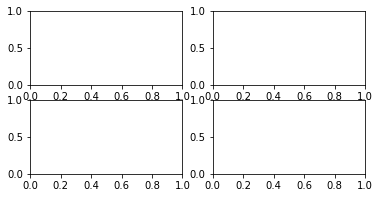

In [9]:
## 单个产品销售拆转单
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
fig, ax = plt.subplots(2,2,figsize =(6,3))
product_data = transfer_product[(transfer_product['default_warehouse'] == 'YJ')
                 &(transfer_product['actual_warehouse'] == 'HQ')
                 &(transfer_product['platform_name'] == 'Decathlon天猫旗舰店' )
                 &(transfer_product['product_id'] == 752871)
                 ]
fig.plot(product_data['paytime'],product_data['transfer_nums'],label='transfer_nums')
fig.plot(product_data['paytime'],product_data['sales_nums'],label='sales_nums')
fig.tick_params(axis='x',which='major',labelrotation= 6)
##plt.legend(loc = "best")
fmt_half_year = mdates.DayLocator(interval=6)
ax.xaxis.set_major_locator(fmt_half_year)

In [98]:
transfer_product[transfer_product['product_id']== 2500810 ]

,paytime,default_warehouse,actual_warehouse,platform_name,product_id,model_code,transfer_order,transfer_nums,sales_order,sales_nums
4200,2022-09-03,DG,HQ,Decathlon天猫旗舰店,2500810,8487923,1,1,2,2
4201,2022-09-10,DG,HQ,Decathlon天猫旗舰店,2500810,8487923,1,1,4,4
4202,2022-09-20,DG,HQ,Decathlon天猫旗舰店,2500810,8487923,1,1,3,3
4203,2022-09-25,DG,HQ,Decathlon天猫旗舰店,2500810,8487923,1,1,4,4
4204,2022-09-26,DG,HQ,Decathlon天猫旗舰店,2500810,8487923,1,1,6,6
...,...,...,...,...,...,...,...,...,...,...
72475,2022-09-25,YJ,HQ,迪卡侬抖音旗舰店,2500810,8487923,8,8,38,38
72476,2022-09-26,YJ,HQ,迪卡侬抖音旗舰店,2500810,8487923,7,7,19,19
72477,2022-09-27,YJ,HQ,迪卡侬抖音旗舰店,2500810,8487923,6,6,20,20
72478,2022-09-28,YJ,HQ,迪卡侬抖音旗舰店,2500810,8487923,1,1,14,14


In [70]:
transfer_product_agg = transfer_product.groupby(['default_warehouse','actual_warehouse','platform_name','product_id']).agg({'transfer_order':'sum','transfer_nums':'sum','sales_order':'sum','sales_nums':'sum'}).reset_index().sort_values(by= ['platform_name','transfer_nums'],ascending = False)

In [71]:
transfer_product

,default_warehouse,actual_warehouse,platform_name,product_id,transfer_order,transfer_nums,sales_order,sales_nums
23279,HQ,DG,锦江之星JINJIANG,4124777,4,4,4,4
23277,HQ,DG,锦江之星JINJIANG,2027371,1,3,1,3
8664,DG,HQ,锦江之星JINJIANG,4132632,2,2,2,2
8666,DG,HQ,锦江之星JINJIANG,4565267,1,2,1,2
36192,HQ,YJ,锦江之星JINJIANG,646219,2,2,2,2
...,...,...,...,...,...,...,...,...
50753,YJ,HQ,Decathlon天猫旗舰店,4834189,1,1,1,1
50754,YJ,HQ,Decathlon天猫旗舰店,4835679,1,1,1,1
50759,YJ,HQ,Decathlon天猫旗舰店,4838455,1,1,1,1
50764,YJ,HQ,Decathlon天猫旗舰店,4845181,1,1,1,1


In [72]:
transfer_product_agg = transfer_product_agg[transfer_product_agg['platform_name'].isin([ '迪卡侬抖音旗舰店', '迪卡侬儿童天猫旗舰店', '迪卡侬京东旗舰店', '迪卡侬CUBE',
       'mini program', 'PINGAN', 'Decathlon天猫旗舰店'])]

In [106]:
transfer_product_agg[transfer_product_agg['platform_name']=='Decathlon天猫旗舰店']

,default_warehouse,actual_warehouse,platform_name,product_id,transfer_order,transfer_nums,sales_order,sales_nums
42818,YJ,HQ,Decathlon天猫旗舰店,752871,432,540,1350,1628
47379,YJ,HQ,Decathlon天猫旗舰店,4172549,291,536,618,1096
47380,YJ,HQ,Decathlon天猫旗舰店,4172550,240,477,485,922
42819,YJ,HQ,Decathlon天猫旗舰店,752876,420,451,1204,1275
47738,YJ,HQ,Decathlon天猫旗舰店,4237674,148,350,656,892
...,...,...,...,...,...,...,...,...
50753,YJ,HQ,Decathlon天猫旗舰店,4834189,1,1,1,1
50754,YJ,HQ,Decathlon天猫旗舰店,4835679,1,1,1,1
50759,YJ,HQ,Decathlon天猫旗舰店,4838455,1,1,1,1
50764,YJ,HQ,Decathlon天猫旗舰店,4845181,1,1,1,1


In [89]:
transfer_product_agg.groupby(['default_warehouse','actual_warehouse','platform_name']).head(10)

,default_warehouse,actual_warehouse,platform_name,product_id,transfer_order,transfer_nums,sales_order,sales_nums
61665,YJ,HQ,迪卡侬抖音旗舰店,2500810,121,122,459,460
61848,YJ,HQ,迪卡侬抖音旗舰店,4100173,103,103,215,215
61666,YJ,HQ,迪卡侬抖音旗舰店,2500811,94,96,417,420
42586,YJ,DG,迪卡侬抖音旗舰店,2033561,3,84,10,280
61611,YJ,HQ,迪卡侬抖音旗舰店,2033561,3,84,10,280
...,...,...,...,...,...,...,...,...
37616,YJ,DG,Decathlon天猫旗舰店,4063238,39,39,41,41
9952,DG,YJ,Decathlon天猫旗舰店,4104796,38,38,79,81
39040,YJ,DG,Decathlon天猫旗舰店,4800357,6,37,28,148
38061,YJ,DG,Decathlon天猫旗舰店,4248040,2,36,9,87


In [79]:
transfer_product.groupby(['default_warehouse','actual_warehouse','platform_name','product_id']).agg({'transfer_order':'sum','transfer_nums':'sum','sales_order':'sum','sales_nums':'sum'}).head(1)

,,,,transfer_order,transfer_nums,sales_order,sales_nums
default_warehouse,actual_warehouse,platform_name,product_id,,,,
DG,HQ,Decathlon天猫旗舰店,38681,1,1,1,1


## ***产品入库情况***

In [12]:
##分月份产品入库情况

month_stock = """ select to_char(create_time,'YYYY-MM'),bn,branch_bn,sum(nums) 
from public.f_online_stock_movement fosm  
where type_name  = '采购入库' and create_time  > '2021-01-01' and branch_bn in('KW-HNC','KW-HQC','KW-YJC')
group by to_char(create_time,'YYYY-MM'),bn,branch_bn"""
cur = conn.cursor()
cur.execute(month_stock)
rows = cur.fetchall()
month_stock = pd.DataFrame(rows,columns = ['creat_time','item_code','branch_bn','nums'])

In [33]:
month_stock_top = month_stock[month_stock['item_code'].isin(list(month_stock.groupby(['item_code']).agg({'nums':'sum'}).reset_index().sort_values(by = 'nums', ascending = False).head(10)['item_code']))]
month_stock_top

,creat_time,item_code,branch_bn,nums
960,2021-01,752871,KW-HNC,260
961,2021-01,752871,KW-HQC,880
962,2021-01,752871,KW-YJC,230
1080,2021-01,798102,KW-HNC,300
1081,2021-01,798102,KW-HQC,1185
...,...,...,...,...
1007849,2023-01,4172498,KW-YJC,25
1007850,2023-01,4172499,KW-HQC,25
1007851,2023-01,4172499,KW-YJC,10
1007853,2023-01,4172549,KW-HNC,50


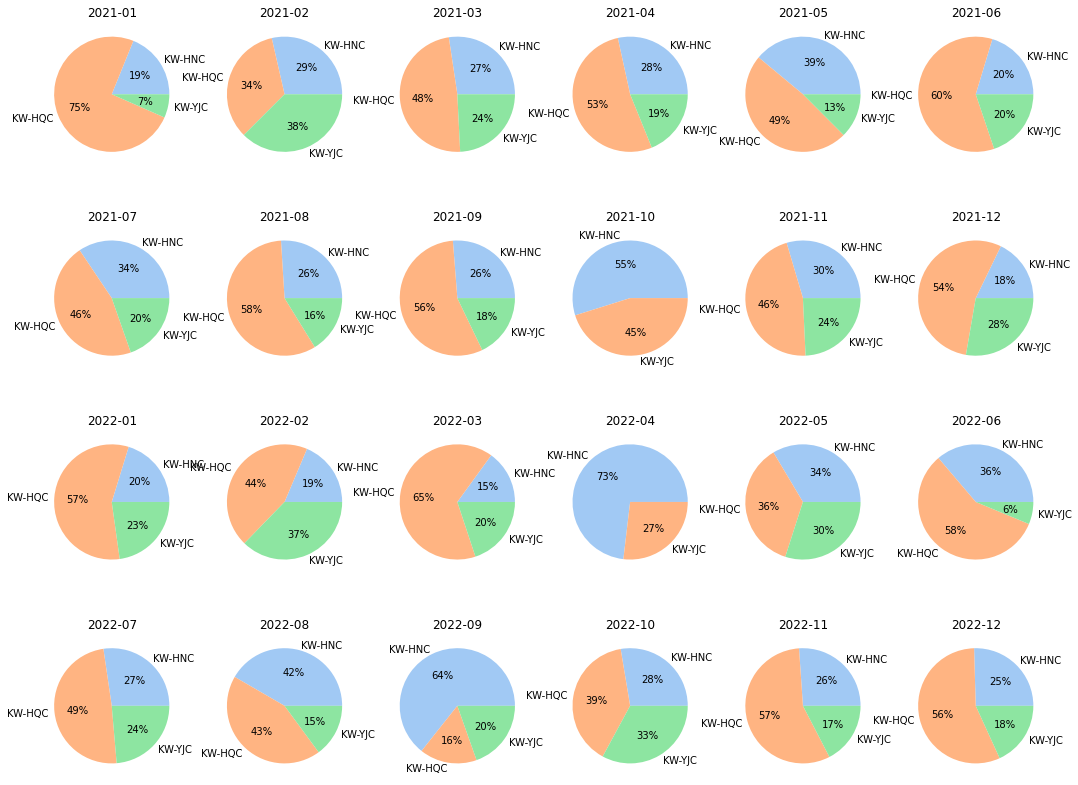

In [114]:
import matplotlib.pyplot as plt
import seaborn as sns
## 某款产品库存补货情况
item_id = 798102
fig,axes = plt.subplots(4, 6, figsize=(20, 30))
month_list = list(month_stock_top[(month_stock_top['item_code']==item_id)]['creat_time'].unique())
month_n = len(month_list)
axes[0][0].pie(month_stock_top[(month_stock_top['item_code']==item_id)&(month_stock_top['creat_time']==month_list[0])]['nums'], 
        labels = month_stock_top[(month_stock_top['item_code']==item_id)&(month_stock_top['creat_time']==month_list[0])]['branch_bn'],
        colors = colors, autopct='%.0f%%')
axes[0][0].set_title(month_list[0])
for i in range(1,month_n):
    a = i//6
    b = i%6
    axes[a][b].pie(month_stock_top[(month_stock_top['item_code']==item_id)&(month_stock_top['creat_time']==month_list[i])]['nums'], 
            labels = month_stock_top[(month_stock_top['item_code']==item_id)&(month_stock_top['creat_time']==month_list[i])]['branch_bn'],
            colors = colors, autopct='%.0f%%')
    axes[a][b].set_title(month_list[i])
plt.subplots_adjust(left=0.2, bottom=None, right=None, top=None, wspace=None, hspace=-0.8)


In [128]:
import datetime
from dateutil.relativedelta import relativedelta
month_1 = datetime.datetime.today()- relativedelta(months=+1)
month_1.year


datetime.datetime.today().strftime('%Y-%m-%d')
from dateutil.relativedelta import relativedelta
datetime.datetime.today()- relativedelta(months=+6)).strftime('%Y-%m-%d')

'2022-07-03'

## ***产品销售情况***

In [156]:
month_sales = """ select to_char(ship_time,'YYYY-MM'),adj_warehouse,product_id,SUM(nums) as nums 
from bi.f_transport_omni_new where ship_time > '2021-01-01' and adj_warehouse in ('燕郊','东莞','花桥')
group by to_char(ship_time,'YYYY-MM'),adj_warehouse,product_id """
cur = conn.cursor()
cur.execute(month_sales)
rows = cur.fetchall()
month_sales = pd.DataFrame(rows,columns = ['ship_month','warehouse','item_code','nums'])
conn.close()

In [162]:
month_sales = pd.DataFrame(rows,columns = ['ship_month','warehouse','item_code','nums'])


In [163]:
warehouse_map ={'东莞':'KW-HNC','花桥':'KW-HQC','燕郊':'KW-YJC'}
month_sales['warehouse']=month_sales['warehouse'].map(warehouse_map)
month_sales 

,ship_month,warehouse,item_code,nums
0,2021-01,东莞,5584,1
1,2021-01,东莞,14506,1
2,2021-01,东莞,16030,7
3,2021-01,东莞,16079,4
4,2021-01,东莞,16547,1
...,...,...,...,...
1489457,2023-01,花桥,4878599,1
1489458,2023-01,花桥,4913881,1
1489459,2023-01,花桥,4913882,1
1489460,2023-01,花桥,4925175,2


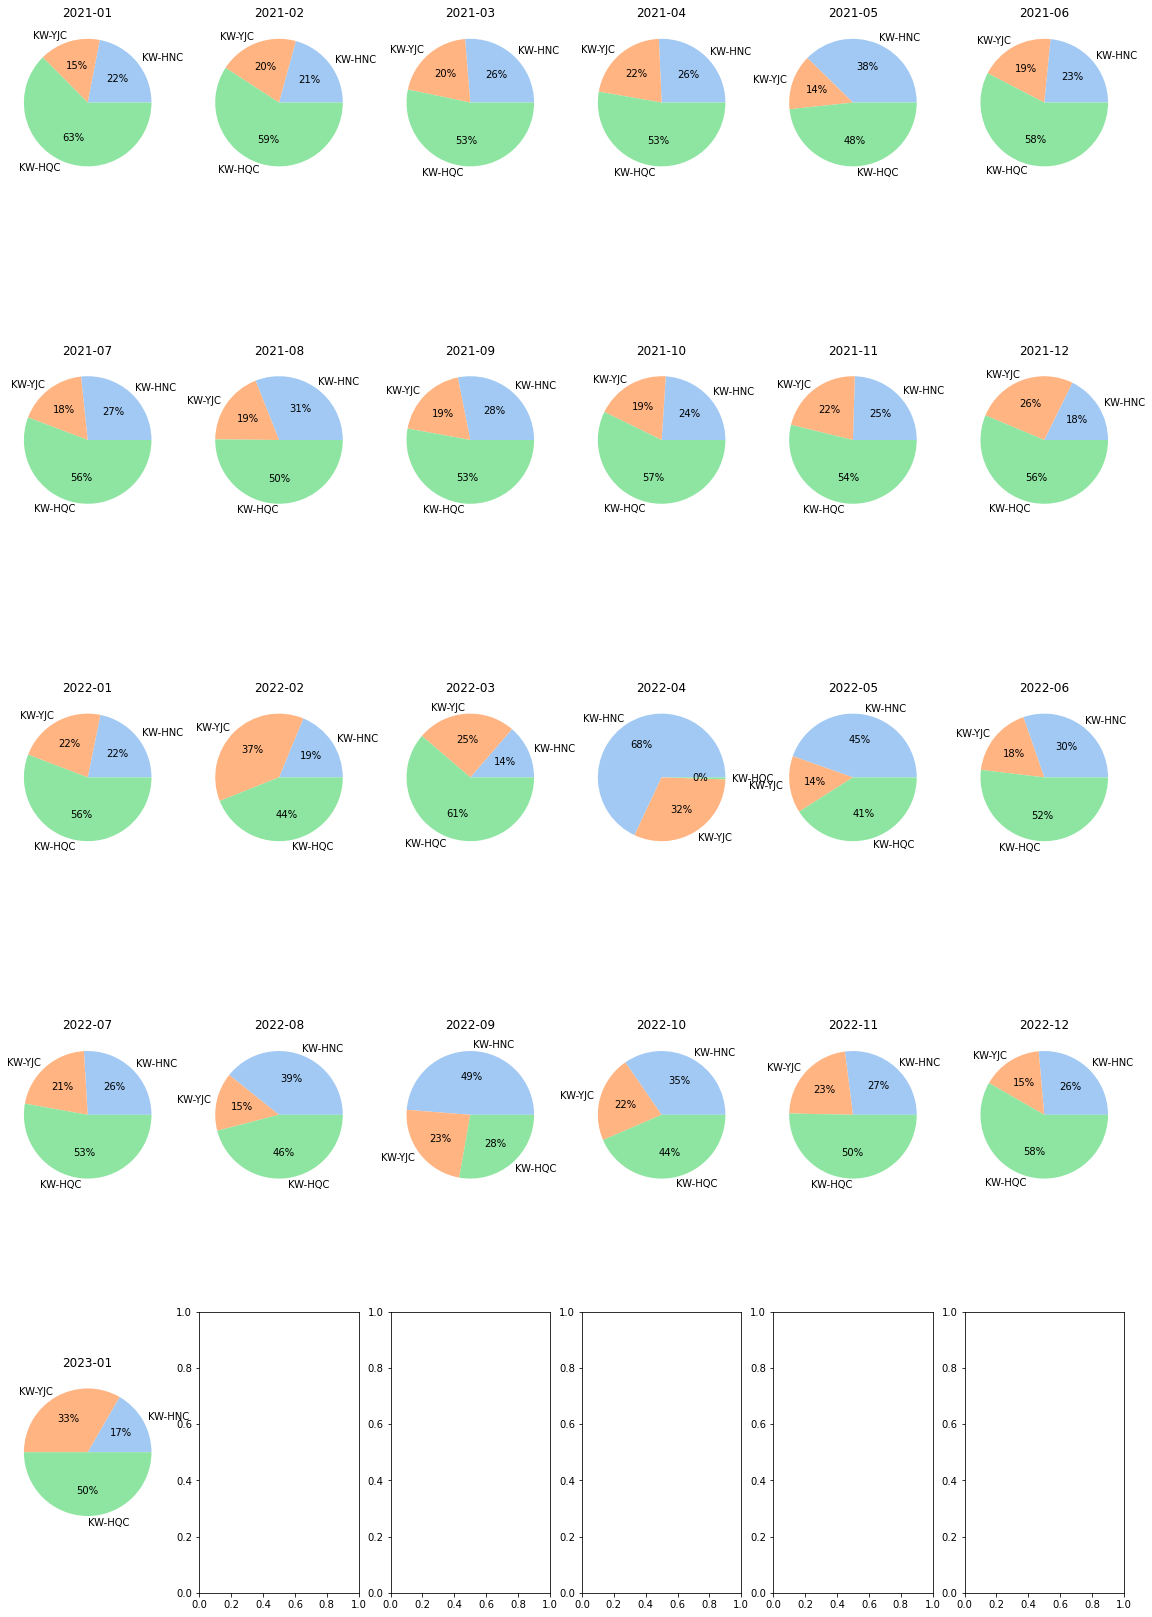

In [171]:
import matplotlib.pyplot as plt
import seaborn as sns
## 某款产品仓库销售情况
item_id = 798102
fig,axes = plt.subplots(5, 6, figsize=(20, 30))
month_list = list(month_sales[(month_sales['item_code']==item_id)]['ship_month'].unique())
month_n = len(month_list)
axes[0][0].pie(month_sales[(month_sales['item_code']==item_id)&(month_sales['ship_month']==month_list[0])]['nums'], 
        labels = month_sales[(month_sales['item_code']==item_id)&(month_sales['ship_month']==month_list[0])]['warehouse'],
        colors = colors, autopct='%.0f%%')
axes[0][0].set_title(month_list[0])
for i in range(1,month_n):
    a = i//6
    b = i%6
    axes[a][b].pie(month_sales[(month_sales['item_code']==item_id)&(month_sales['ship_month']==month_list[i])]['nums'], 
            labels = month_sales[(month_sales['item_code']==item_id)&(month_sales['ship_month']==month_list[i])]['warehouse'],
            colors = colors, autopct='%.0f%%')
    axes[a][b].set_title(month_list[i])
## plt.subplots_adjust(left=0.2, bottom=None, right=None, top=None, wspace=None, hspace=-0.8)

## ***产品的转单情况***

In [175]:
## 查看by month的transfer rate与仓库补货销售差异的关系
## Sample 10月转单情况

product_query = (""" select f1.paytime,f1."Default_warehouse",actual_warehouse,f1.platform_name,f1.product_id,f1.model_code, transfer_order, transfer_nums,sales_order,sales_nums
from 
(select to_char(paytime,'YYYY-MM-DD') as paytime,"Default_warehouse",actual_warehouse,platform_name,product_id,model_code,count(distinct order_bn) as transfer_order,sum(nums) as transfer_nums
from 
(select  *,case when adj_warehouse ='燕郊' then 'YJ'
				when adj_warehouse ='东莞' then 'DG'
				when adj_warehouse ='花桥' then 'HQ' 
				when adj_warehouse ='武汉' then 'WH'  end as actual_warehouse
from bi.f_transport_omni fto  where ship_time between '2022-09-01 00:00:00' and '2022-10-01 00:00:00'   and adj_warehouse   in ('燕郊','东莞','花桥') )f
where actual_warehouse != "Default_warehouse"     and order_bn  in
(select order_bn  from bi.f_transport_omni fto  
where ship_time between '2022-09-01 00:00:00' and '2022-10-01 00:00:00'
group by order_bn
having count(distinct logi_no)= 1)
group by "Default_warehouse",actual_warehouse,platform_name,product_id,model_code,to_char(paytime,'YYYY-MM-DD')
order by count(distinct order_bn) desc) f1
left join 
(select to_char(paytime,'YYYY-MM-DD') as paytime ,"Default_warehouse",platform_name,product_id,model_code,count(distinct order_bn) as sales_order,sum(nums) as sales_nums from bi.f_transport_omni 
where ship_time between '2022-09-01 00:00:00' and '2022-10-01 00:00:00' 
		and adj_warehouse   in ('燕郊','东莞','花桥') and "Default_warehouse" in ('HQ','YJ','DG')
group by "Default_warehouse",platform_name,product_id,model_code,to_char(paytime,'YYYY-MM-DD')) f2
on f1."Default_warehouse" = f2."Default_warehouse" and f1.product_id = f2.product_id and f1.platform_name = f2.platform_name and f1.paytime = f2.paytime
""")
cur = conn.cursor()
cur.execute(product_query)
rows = cur.fetchall()
transfer_product = pd.DataFrame(rows,columns = ['paytime','default_warehouse','actual_warehouse','platform_name','product_id','model_code','transfer_order','transfer_nums','sales_order','sales_nums'])

transfer_product[transfer_product['product_id']==798102].groupby(['paytime']).agg({'transfer_nums':'sum','sales_nums':'sum'})


,transfer_nums,sales_nums
paytime,,
2022-09-01,3,94
2022-09-02,3,76
2022-09-03,9,78
2022-09-04,1,17
2022-09-05,3,24
2022-09-06,8,269
2022-09-07,9,161
2022-09-08,26,143
2022-09-09,50,131


In [10]:
import datetime
from dateutil.relativedelta import relativedelta
product_data_ttl = pd.DataFrame(columns = ['paytime','platform_name','ship_city','ship_province','warehouse','default_warehouse','product_id'
                                            ,'total_amount','sales_amount','margin','nums','cost_amount','cost_amount_updated','sales_related_sap_price','price_from_sap'
                                            ,'adj_warehouse','model_code','model_name','family_id','family_label_en'])
start_day = datetime.datetime(2021, 11, 1, 0, 0, 0)
end_day = start_day+relativedelta(months = +1)
print(start_day,end_day)
for i in range(11,13):
    current_time = datetime.datetime.now()
    query_data = ("""  select to_char(paytime,'YYYY-MM-DD') as paytime ,platform_name,ship_city,ship_province ,warehouse,"Default_warehouse" as default_warehouse,product_id,
            SUM(total_amount) as total_amount,sum(sales_amount) as sales_amount,sum(margin)as margin,
            sum(nums) as nums,sum(cost_amount) as cost_amount,sum(cost_amount_updated) as cost_amount_updated,sum(sales_related_sap_price) as sales_related_sap_price,
            sum(price_from_sap) as price_from_sap
            ,max(adj_warehouse) as adj_warehouse,max(model_code) as model_code ,max(model_name) as model_name,max("Family Id") as family_id,max(family_label_en) as family_label_en 
            from bi.f_transport_omni where paytime between '{a}' and '{b}'
            group by to_char(paytime,'YYYY-MM-DD'),platform_name,ship_city,ship_province ,warehouse,"Default_warehouse",product_id
    """).format(a=start_day , b=end_day )
    cur = conn.cursor()
    cur.execute(query_data)
    rows = cur.fetchall()
    product_data = pd.DataFrame(rows,columns = ['paytime','platform_name','ship_city','ship_province','warehouse','default_warehouse','product_id'
                                                ,'total_amount','sales_amount','margin','nums','cost_amount','cost_amount_updated','sales_related_sap_price','price_from_sap'
                                                ,'adj_warehouse','model_code','model_name','family_id','family_label_en'])
    start_day = start_day+relativedelta(months = +1)
    end_day = start_day+relativedelta(months = +1)
    end_time = datetime.datetime.now()
    print("current_time:    " + str(end_time-current_time))
    print(start_day,end_day)
    file_dir = 'D:/product_data/product_data_2021' + str(i)+'.csv'
    product_data.to_csv(file_dir)

2021-11-01 00:00:00 2021-12-01 00:00:00
current_time:    0:05:38.136129
2021-12-01 00:00:00 2022-01-01 00:00:00
current_time:    0:03:31.520560
2022-01-01 00:00:00 2022-02-01 00:00:00


In [8]:
conn.close()

In [180]:
colunms_name_query = """SELECT 
               column_name
   FROM information_schema.columns sc
   WHERE table_schema = 'bi'
     AND table_name like 'f_transport_omni'"""
cur = conn.cursor()
cur.execute(colunms_name_query)
rows = cur.fetchall()
colunms_name = pd.DataFrame(rows,columns = ['name'])
colunms_name = list(colunms_name['name'])
colunms_name

In [1]:
import pandas as pd
import os
import polars as pl

In [2]:
raw_data = pl.read_csv(r'C:\Users\Administrator\Desktop\product_data_2021_2022\product_data_2022_0.csv')
raw_data_1 = pl.read_csv(r'C:\Users\Administrator\Desktop\product_data_2021_2022\product_data_2022_1.csv')

In [3]:
raw_data = pl.concat([raw_data,raw_data_1])

In [4]:
warehouse_data = raw_data.groupby(['paytime','warehouse','default_warehouse','product_id']).agg(
        [pl.col("nums").sum(), ]).sort(["nums"], reverse=True)
warehouse_data

paytime,warehouse,default_warehouse,product_id,nums
str,str,str,i64,i64
"""2022-02-25""","""酷武花桥""","""HQ""",4568864,560
"""2022-02-08""","""酷武花桥""","""DG""",45657,527
"""2022-02-14""","""酷武花桥""","""HQ""",4568864,520
"""2022-02-25""","""酷武花桥""","""HQ""",4568865,320
"""2022-02-09""","""酷武东莞""","""DG""",2896758,316
"""2022-01-09""","""酷武花桥""","""HQ""",2308147,313
"""2022-02-15""","""酷武花桥""","""HQ""",4101996,232
"""2022-01-19""","""酷武东莞""","""HQ""",2768942,216
"""2022-02-21""","""酷武花桥""","""HQ""",4101996,211


In [23]:
def adj_warehouse(x):
    if x.__contains__('花桥'):
        return 'HQ'
    elif x.__contains__('东莞'):
        return 'DG'
    elif x.__contains__('燕郊'):
        return 'YJ'
    else: return 'ADJ'


In [33]:
## 月度整体趋势分析
file_name = os.listdir(r'C:\Users\Administrator\Desktop\product_data_2021_2022')
ge = 0
for i in file_name:
    print(i)
    file_dir = 'C:/Users/Administrator/Desktop/product_data_2021_2022/'+i
    raw_data = pl.read_csv(file_dir,ignore_errors= True)
    ## 生成年月日字段
    time_dimen = ["year", "month", "day"]
    raw_data = raw_data.with_columns(
        pl.col('paytime').str.split("-").alias("time_list")
    ).with_column(
        pl.struct([
            pl.col("time_list").arr.get(i).alias(time_dimen[i]) for i in range(3)
        ]).alias("time_list"), 
    ).unnest('time_list')
    ## 默认仓销售情况
    default_sales_data = raw_data.filter(pl.col('warehouse').str.contains('花桥|东莞|燕郊')).groupby(['year','month','default_warehouse','product_id']).agg(
    [pl.col("nums").sum(), ]).sort(['year','month',"nums"], reverse=True)
    default_sales_data = default_sales_data.with_columns([(pl.col('nums')/pl.col('nums').sum()).over(['year','month','product_id']).alias('nums_pct')])

    ## 默认仓分天仓库的转单情况
    transfer_sales_data = raw_data.filter(pl.col('warehouse').str.contains('花桥|东莞|燕郊')).with_columns(
                         pl.col("warehouse").apply(lambda x: adj_warehouse(x)).alias("adj_warehouse")
                         ).filter(pl.col('adj_warehouse')!=pl.col('default_warehouse')).groupby(
                        ['year','month','default_warehouse','product_id']).agg([pl.col("nums").sum(), ])
    transfer_sales_data = transfer_sales_data.rename({"nums": "transfer_nums"})

    ## 连接两表计算当天转单率
    sales_data = default_sales_data.join(transfer_sales_data, on=['year','month',"default_warehouse","product_id"], how="left")
    sales_data = sales_data.with_columns(
            [pl.col("transfer_nums").fill_null(pl.lit(0),).alias("transfer_nums"),]
        ).with_columns(
            [ (pl.col("transfer_nums")/pl.col("nums")).alias("transfer_rate"),]
        )
    if ge == 0:
         sales_data_month = sales_data.cleared()
    ge+=1
    sales_data_month = pl.concat([sales_data_month, sales_data])

product_data_20211.csv
product_data_202110.csv
product_data_202111.csv
product_data_202112.csv
product_data_20212.csv
product_data_20213.csv
product_data_20214.csv
product_data_20215.csv
product_data_20216.csv
product_data_20217.csv
product_data_20218.csv
product_data_20219.csv
product_data_2022_0.csv
product_data_2022_1.csv
product_data_2022_10.csv
product_data_2022_11.csv
product_data_2022_2.csv
product_data_2022_3.csv
product_data_2022_4.csv
product_data_2022_5.csv
product_data_2022_6.csv
product_data_2022_7.csv
product_data_2022_8.csv
product_data_2022_9.csv
product_data_2023_0.csv


In [42]:
sales_data_month.filter((pl.col('transfer_rate')>0.9)&(pl.col('transfer_nums')>500)
                       ).groupby(['product_id']).agg(pl.col("transfer_nums").count()
                       ).sort(by = ['transfer_nums'],reverse = True)

product_id,transfer_nums
i64,u32
4568864,4
4568866,4
4568863,4
4568865,3
4572941,3
4568859,2
4644102,2
4572982,2
4688140,2


In [55]:
sales_data_month.filter((pl.col('transfer_rate')>0.4)&(pl.col('transfer_nums')>50)
                       ).select(pl.col("transfer_nums").sum()
                       )

transfer_nums
i64
1518516


In [52]:
sales_data_month.select(pl.col("transfer_nums").sum())

transfer_nums
i64
7003769


In [47]:
sales_data_month.select(pl.col('transfer_nums').sum())

transfer_nums
i64
7003769


In [43]:
sales_data_month.filter(pl.col('product_id')==4568864)

year,month,default_warehouse,product_id,nums,nums_pct,transfer_nums,transfer_rate
str,str,str,i64,i64,f64,i64,f64
"""2021""","""10""","""HQ""",4568864,5568,0.745282,0,0.0
"""2021""","""10""","""YJ""",4568864,1903,0.254718,1903,1.0
"""2021""","""11""","""HQ""",4568864,3516,0.854227,0,0.0
"""2021""","""11""","""YJ""",4568864,600,0.145773,600,1.0
"""2021""","""12""","""HQ""",4568864,1799,0.656809,0,0.0
"""2021""","""12""","""YJ""",4568864,940,0.343191,940,1.0
"""2021""","""09""","""HQ""",4568864,10080,0.569717,0,0.0
"""2021""","""09""","""YJ""",4568864,7613,0.430283,7613,1.0
"""2022""","""02""","""HQ""",4568864,1080,0.84375,0,0.0


In [42]:
import polars as pl 
raw_data = pl.read_csv("D:/product_data_2021_2022/product_data_2022_5.csv")

FileNotFoundError: No such file or directory: D:/product_data_2021_2022/product_data_2022_5.csv

In [1]:
import polars as pl 
raw_data = pl.read_csv("C:/Users/Administrator/Desktop/product_data_2021_2022/product_data_2022_5.csv")

In [6]:
# 默认仓三仓的占比销售情况变化与转单率的关系

## 默认仓分天的实际销售情况以及各仓库的销量占比
default_sales_data = raw_data.filter(pl.col('warehouse').str.contains('花桥|东莞|燕郊')).groupby(['paytime','default_warehouse','product_id']).agg(
    [pl.col("nums").sum(), ]).sort(["paytime","nums"], reverse=True)
default_sales_data = default_sales_data.with_columns([(pl.col('nums')/pl.col('nums').sum()).over(['paytime','product_id']).alias('nums_pct')])
default_sales_data

## 默认仓分天仓库的转单情况
transfer_sales_data = raw_data.filter(pl.col('warehouse').str.contains('花桥|东莞|燕郊')).with_columns(
                     pl.col("warehouse").apply(lambda x: adj_warehouse(x)).alias("adj_warehouse")
                     ).filter(pl.col('adj_warehouse')!=pl.col('default_warehouse')).groupby(
                    ['paytime','default_warehouse','product_id']).agg([pl.col("nums").sum(), ])
transfer_sales_data = transfer_sales_data.rename({"nums": "transfer_nums"})

## 连接两表计算当天转单率
sales_data = default_sales_data.join(transfer_sales_data, on=["paytime","default_warehouse","product_id"], how="left")
sales_data = sales_data.with_columns(
        [pl.col("transfer_nums").fill_null(pl.lit(0),).alias("transfer_nums"),]
    ).with_columns(
        [ (pl.col("transfer_nums")/pl.col("nums")).alias("transfer_rate"),]
    )

## 将时间数据拆分为年月日
time_dimen = ["year", "month", "day"]
sales_data = sales_data.with_columns(
    pl.col('paytime').str.split("-").alias("time_list")
).with_column(
    pl.struct([
        pl.col("time_list").arr.get(i).alias(time_dimen[i]) for i in range(3)
    ]).alias("time_list"), 
).unnest('time_list')


## 月销各仓库占比情况，计算每日销售仓库占比与月销占比的差异作为单个产品的默认仓分布波动情况以及销量波动情况
monthly_transfer = sales_data.with_columns([(pl.col('nums').sum()).over(['year','month','product_id']).alias('month_nums')]
                       ).with_columns([(pl.col('nums').sum()/pl.col('month_nums')).over(['year','month','default_warehouse','product_id']).alias('month_nums_pct')]
                       ).with_columns(((pl.col('nums_pct')-pl.col('month_nums_pct'))**2*pl.col('nums')/pl.col('month_nums')).alias('warehouse_flip') ## 计算单日仓库分布与全月分布的差异后平方乘以当日销量在全月销量占比
                       ).groupby(['year','month','product_id']).agg(
        [
            pl.col("warehouse_flip").sum(),
            pl.col("month_nums_pct").var().alias('sales_flip'),
            (pl.col("transfer_nums").sum()/pl.col("nums").sum()).alias('month_transfer_rate'),
            pl.col("nums").sum().alias('month_sales_nums')
        ]
    )

## 计算产品销售的波动情况

In [7]:
family_map = raw_data.groupby(['product_id']).agg(pl.col("family_id").max())
monthly_transfer = monthly_transfer.join(family_map,how = 'left',on = 'product_id')

E:\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

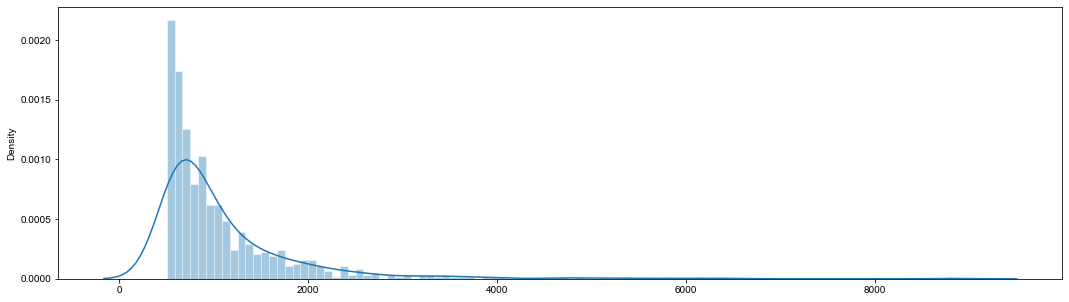

In [8]:
## 产品月销量分布
import seaborn as sns
import matplotlib.pyplot as plt
fig = plt.subplots(figsize =(18,5))
sns.set_theme(style="darkgrid")
sns.distplot(monthly_transfer[:,['month_sales_nums']].filter(pl.col('month_sales_nums')>500),kde = True,bins= 100)

In [9]:
## 三仓的转单情况
sales_data.groupby(['year','month','default_warehouse']).agg([pl.col('transfer_nums').sum()/pl.col('nums').sum()])

year,month,default_warehouse,transfer_nums
str,str,str,f64
"""2022""","""01""",null,1.0
"""2022""","""02""","""HQ""",0.176227
"""2022""","""01""","""YJ""",0.232794
"""2022""","""01""","""DG""",0.165735
"""2022""","""02""",null,1.0
"""2022""","""01""","""HQ""",0.14953
"""2022""","""02""","""YJ""",0.178899
"""2022""","""02""","""DG""",0.162437


In [10]:
## 销售波动和
monthly_transfer.filter(pl.col("month_sales_nums")>500).select(pl.col(["warehouse_flip","sales_flip","month_transfer_rate"])).pearson_corr()

warehouse_flip,sales_flip,month_transfer_rate
f64,f64,f64
1.0,-0.059101,0.376753
-0.059101,1.0,0.113119
0.376753,0.113119,1.0


从当前的数据看拆转单率的变化更受到销售默认仓占比的变化的影响而不是整体销售趋势的变化

<AxesSubplot:xlabel='sales_flip', ylabel='month_transfer_rate'>

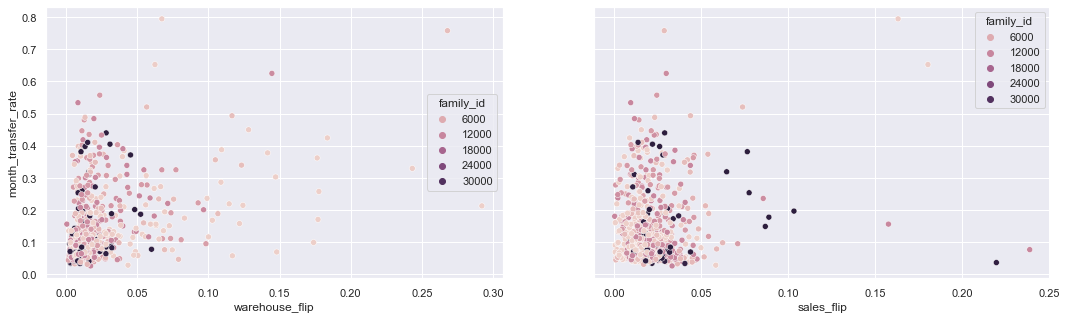

In [11]:
fig, axes = plt.subplots(1, 2, figsize =(18,5),sharey = True)
sns.scatterplot(
    data=monthly_transfer.filter(pl.col("month_sales_nums")>500),
    x="warehouse_flip", y="month_transfer_rate",hue = "family_id",ax = axes[0]
)
sns.scatterplot(
    data=monthly_transfer.filter(pl.col("month_sales_nums")>500),
    x="sales_flip", y="month_transfer_rate",hue = "family_id",ax = axes[1]
)

整体从当前散点图来看默认仓区域销售占比的变化和拆转单率的变化成正比, 销售量级的波动情况对于转单率的影响相对比较明显的趋势关系

In [ ]:
## 销售预测
product_id = 1779336
file_name = os.listdir(r'C:\Users\Administrator\Desktop\product_data_2021_2022')
for i in file_name:
    file_dir = 'C:/Users/Administrator/Desktop/product_data_2021_2022/'+file_name
    raw_data = pl.read_csv(file_dir)
    raw_data = raw_data.
    warehouse_data